<a href="https://colab.research.google.com/github/Abby-Wale/CNN_For_Dementia/blob/main/model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet


In [2]:
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import torchvision
from torchvision import models
from torch.autograd import Variable
from torch.optim import Adam

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/download?datasetVersionNumber=1'
od.download(dataset_url)

100%|██████████| 28.0M/28.0M [00:01<00:00, 23.1MB/s]


In [4]:
dementia_data = '/content/alzheimer-mri-dataset/Dataset'

In [5]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Non_Demented : 3200
Moderate_Demented : 64
Mild_Demented : 896
Very_Mild_Demented : 2240


In [6]:
num_img = {}
for dir in os.listdir(dementia_data):
  num_img[dir] = len(os.listdir(os.path.join(dementia_data,dir)))

num_img.items()

def datafolder(folder, split):
    base_path = os.path.dirname(dementia_data)
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        for dir in os.listdir(dementia_data):
            os.makedirs(os.path.join(folder_path, dir))
            for img in np.random.choice(a=os.listdir(os.path.join(dementia_data, dir)), size=(math.floor(split * num_img[dir]) - 5), replace=False):
                O = os.path.join(dementia_data, dir, img)
                D = os.path.join(folder_path, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print('the folder exists')

In [7]:
datafolder('train', 0.7)
datafolder('val', 0.15)
datafolder('test', 0.15)

In [8]:
train_dataset = '/content/alzheimer-mri-dataset/train'
val_dataset = '/content/alzheimer-mri-dataset/val'
test_dataset = '/content/alzheimer-mri-dataset/test'

In [9]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Non_Demented : 15
Moderate_Demented : 17
Mild_Demented : 16
Very_Mild_Demented : 15


In [10]:
for cls in os.listdir(train_dataset):
    print(cls, ':', len(os.listdir(train_dataset + '/' + cls)))

train_ds = ImageFolder(train_dataset)
print('Lenght of Training Dataset:',  len(train_ds))

Non_Demented : 2235
Moderate_Demented : 39
Mild_Demented : 622
Very_Mild_Demented : 1563
Lenght of Training Dataset: 4459


In [11]:
for cls in os.listdir(val_dataset):
    print(cls, ':', len(os.listdir(val_dataset + '/' + cls)))

valid_ds = ImageFolder(val_dataset)
valid_count = len(valid_ds)
print('Lenght of Validation Dataset:',  len(valid_ds))

Non_Demented : 475
Moderate_Demented : 4
Mild_Demented : 129
Very_Mild_Demented : 331
Lenght of Validation Dataset: 939


In [12]:
'''This code loads all the images from a specified directory (`data_dir`), 
applies a series of random transformations to each image to generate new 
augmented versions of them, and saves the augmented images to a new 
directory (`preview/`). You can adjust the number of augmented images 
generated for each original image by changing the range value in this 
line of code: `imgs = [transform(img) for _ in range(21)]` '''

# Define the transformations
transform = tt.Compose([
    tt.RandomRotation(40),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomAffine(0, shear=20, scale=(0.8, 1.2)),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    tt.RandomResizedCrop(150, scale=(0.8, 1.2)),
    tt.ToTensor()
])

# Set the path to the directory containing the images
# data_dir = 'data/train/cats'

# Create a new directory to store the augmented images
preview_dir = 'train_aug'
os.makedirs(preview_dir, exist_ok=True)

# Recursively search for image files in all subdirectories
for subdir, _, files in os.walk(train_dataset):
    for filename in files:
        # Load the image
        image_path = os.path.join(subdir, filename)
        img = Image.open(image_path)

        # Apply the transformations to the image
        imgs = [transform(img) for _ in range(16)]

        # Create a new subdirectory within the `preview/` directory
        # that corresponds to the original subdirectory
        subdir_name = os.path.basename(subdir)
        preview_subdir = os.path.join(preview_dir, subdir_name)
        os.makedirs(preview_subdir, exist_ok=True)

        # Save the transformed images to the new subdirectory
        for i, img in enumerate(imgs):
            save_path = os.path.join(preview_subdir, f'{filename}_{i}.jpeg')
            torchvision.utils.save_image(img, save_path)

In [13]:
train_data = '/content/train_aug'

for cls in os.listdir(train_data):
    print(cls, ':', len(os.listdir(train_data + '/' + cls)))

train_ds = ImageFolder(train_data)
train_count = len(train_ds)
print('Lenght of Training Dataset:',  len(train_ds))

Non_Demented : 35760
Moderate_Demented : 624
Mild_Demented : 9952
Very_Mild_Demented : 25008
Lenght of Training Dataset: 71344


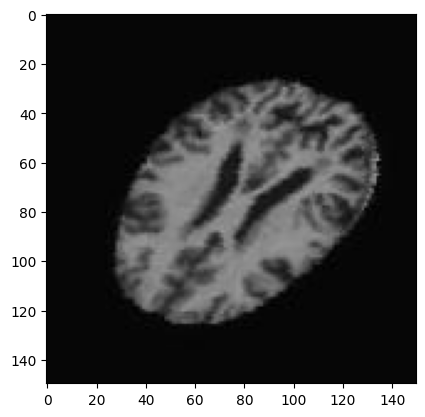

In [14]:
img, label = train_ds[120]
plt.imshow(img)

In [15]:
train_ds = ImageFolder(train_dataset, tt.ToTensor())
means = []
stdevs = []
for img, label in train_ds:
    means.append(np.mean(img.numpy(), axis=(1,2)))
    stdevs.append(np.std(img.numpy(), axis=(1,2)))
means = np.mean(means, axis=0)
stdevs = np.mean(stdevs, axis=0)
stats = (means.tolist(), stdevs.tolist())



train_ds = ImageFolder(train_data, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

valid_ds = ImageFolder(val_dataset, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

test_ds = ImageFolder(test_dataset, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

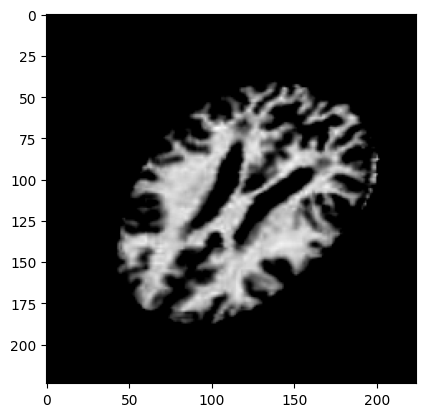

In [16]:
'''image in index 120 after normalization'''
img, label = train_ds[120]
plt.imshow(img.permute((1, 2, 0)))

In [17]:
train_dl = DataLoader(train_ds, 
                      batch_size = 64, 
                      shuffle=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size=32)

test_dl = DataLoader(test_ds, 
                    batch_size = 32)
                    

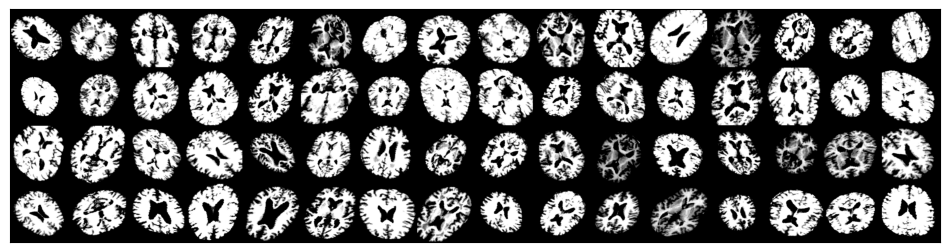

In [18]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [19]:
"""this block helps choose the available accelerator"""

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:


def plot_loss_curves(model_name, train_dl, test_dl, num_epochs, learning_rate, weight_decay):
    device = get_default_device()

    # Define the model
    if model_name == "vgg":
        model = models.vgg16(pretrained=True)
        # Modify the VGG model as needed (e.g., replace the last layer)
        for param in model.parameters():
          param.requires_grad = False

        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = nn.Sequential(nn.Linear(512, 12),
                                 nn.ReLU(),
                                 nn.Linear(12, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 4))
        
          
    elif model_name == "resnet":
        model = models.resnet18(pretrained=True)
        # Modify the ResNet model as needed (e.g., replace the last layer)
        resnet.fc = nn.Sequential(
            nn.Linear(512, 4),
            nn.Sigmoid())
        
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        # Modify the AlexNet model as needed (e.g., replace the last layer)
    else:
        raise ValueError("Invalid model name")

    model.to(device)

    # Loss function
    loss_function = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize lists to store loss and accuracy values
    train_losses = []
    validation_accuracies = []

    best_accuracy = 0.0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_count = 0
        train_accuracy = 0.0

        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
            train_count += labels.size(0)

        train_accuracy = train_accuracy / train_count
        train_loss = train_loss / train_count

        # Evaluation phase
        model.eval()
        valid_count = 0
        validation_accuracy = 0.0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dl):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, prediction = torch.max(outputs.data, 1)
                validation_accuracy += int(torch.sum(prediction == labels.data))
                valid_count += labels.size(0)

        validation_accuracy = validation_accuracy / valid_count

        print(f"Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, "
              f"Validation Accuracy: {validation_accuracy}")

        # Update the lists with loss and accuracy values
        train_losses.append(train_loss)
        validation_accuracies.append(validation_accuracy)

        # Save the best model
        if validation_accuracy > best_accuracy:
            torch.save(model.state_dict(), 'best_checkpoint.model')
            best_accuracy = validation_accuracy

    # Plot the loss curve and validation accuracy curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


###Optimizer



In [ ]:
plot_loss_curves(vgg, train_dl, test_dl, 50, 0.001, 0.0001)


In [ ]:
plot_loss_curves(resnet, train_dl, test_dl, 50, 0.001, 0.0001)
